In [58]:
import pymysql
import os
import pandas as pd
import numpy as np
import re
import jieba
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Input,Dense, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding,concatenate,Flatten,Dropout
from keras.models import Model
from sklearn.metrics import roc_auc_score
from keras.models import model_from_json

from data_utils import *
import pickle


In [2]:
TENCENT_VECTOR_PATH = '/Users/huan/Desktop/weibo/word_vector/Tencent_AILab_ChineseEmbedding.txt'
MAX_VOCAB_SIZE = 50000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 200

In [34]:
def get_user_nlp_data():

    conn = pymysql.connect(host = '127.0.0.1', 
                           user = 'root', 
                           password = 'root123', 
                           db = 'delidou')
    user_desc_tag = pd.read_sql_query('select id,introduction as name,tag from base_user_info', conn)
    user_fans_wc = pd.read_sql_query('select id, comment_cloud from base_user_fans', conn)
    return user_desc_tag, user_fans_wc


def preprocess_texts(df):

    df['clean_name'] = df.name.apply(remove_blanks).apply(replace_puncs).apply(find_chinese).values
    df['cutted_text'] = df.clean_name.apply(cut_text).values
    df['texts'] = df.cutted_text.apply(lambda x:' '.join(x)).values
    df.loc[:,'sequence_length'] = df.cutted_text.apply(lambda x:len(x)).values
    df = df[(df.sequence_length >0) & (df.sequence_length <= MAX_SEQUENCE_LENGTH)]
    return df


def preprocess_user_nlp():
    
    # get data
    user_desc_tag, user_fans_wc = get_user_nlp_data()
    
    # make comment cloud
    clouds = []
    for comment in user_fans_wc.comment_cloud:
        c = json.loads(comment)
        if not len(c)>=5:
            clouds.append('')
            continue
        all_words = ' '
        for dic in c:
            all_words+=dic['name'] +' '
        clouds.append(all_words)

    user_fans_wc.loc[:,'comment_cloud'] = clouds
    
    user_desc_tag = user_desc_tag[~user_desc_tag.name.isnull()]
    user_desc_tag = preprocess_texts(user_desc_tag)
    
    user_desc_tag = user_desc_tag.merge(user_fans_wc, on = 'id', how = 'left')
    user_desc_tag['texts'] = user_desc_tag['texts'] + user_desc_tag['comment_cloud']
    
    nonnull_index = np.where((user_desc_tag.tag != '').values)[0]
    user_desc_tag = user_desc_tag.iloc[nonnull_index,:]
    
    return user_desc_tag

def tokenize_words(df):
    tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
    tokenizer.fit_on_texts(df.texts)
    num_words = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)
    print('Number of word considered: {}'.format(num_words))
    word2index = tokenizer.word_index
    return tokenizer,{'num_words':num_words}

In [38]:
def load_embedding_matrix(tokenizer, num_words):
    word2index = tokenizer.word_index

    embeddings_index = dict()
    with open(TENCENT_VECTOR_PATH,'r', encoding = 'utf-8') as f:
        next(f)
        for line in f:
            values = line.split(' ')
            word = values[0]
            if word in word2index:
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
        f.close()

    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, ind in word2index.items():
        if ind < MAX_VOCAB_SIZE:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[ind] = embedding_vector

    return embedding_matrix

In [42]:
df = preprocess_user_nlp()

tokenizer, configs = tokenize_words(df)
configs['MAX_SEQUENCE_LENGTH'] = MAX_SEQUENCE_LENGTH

sequences = tokenizer.texts_to_sequences(df.texts)

padded_sequences = pad_sequences(sequences,maxlen = MAX_SEQUENCE_LENGTH)
embedding_matrix = load_embedding_matrix(tokenizer, configs['num_words'])

features = padded_sequences

targets = pd.Categorical(df['tag'])
idx_to_cat = {idx:cat for idx, cat in enumerate(pd.Categorical(targets.categories))}
targets = targets.codes
K = max(idx_to_cat) + 1

Number of word considered: 48751


In [45]:
embedding_layer = Embedding(configs['num_words'],
                    EMBEDDING_DIM,
                    weights = [embedding_matrix],
                    input_length = MAX_SEQUENCE_LENGTH,
                    trainable = False)

inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = Embedding(input_dim=configs['num_words'], output_dim=200, 
                               input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix],
                               trainable=False)(inputs)

l_conv01 = Conv1D(128, 2,activation='relu',padding='same')(embedded_sequences)
l_pool01 = MaxPooling1D(2)(l_conv01)
l_conv02 = Conv1D(128, 3,activation='relu',padding='same')(embedded_sequences)
l_pool02 = MaxPooling1D(3)(l_conv02)
l_conv03 = Conv1D(128, 4,activation='relu',padding='same')(embedded_sequences)
l_pool03 = MaxPooling1D(4)(l_conv03)
l_merge = concatenate([l_pool01,l_pool02, l_pool03],axis=1)

l_cov2 = Conv1D(128, 3, activation='relu',padding='same')(l_merge)
l_pool2 = MaxPooling1D(10)(l_cov2)
l_pool2 = Flatten()(l_pool2)
l_dense = Dense(128, activation='relu')(l_pool2)
l_dense = Dropout(0.5)(l_dense)
l_dense = Dense(64, activation='relu')(l_dense)
encoder = Model(inputs, l_dense)

encoded_vector = encoder(inputs)
preds = Dense(K, activation='softmax')(encoded_vector)

model=Model(inputs,preds)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

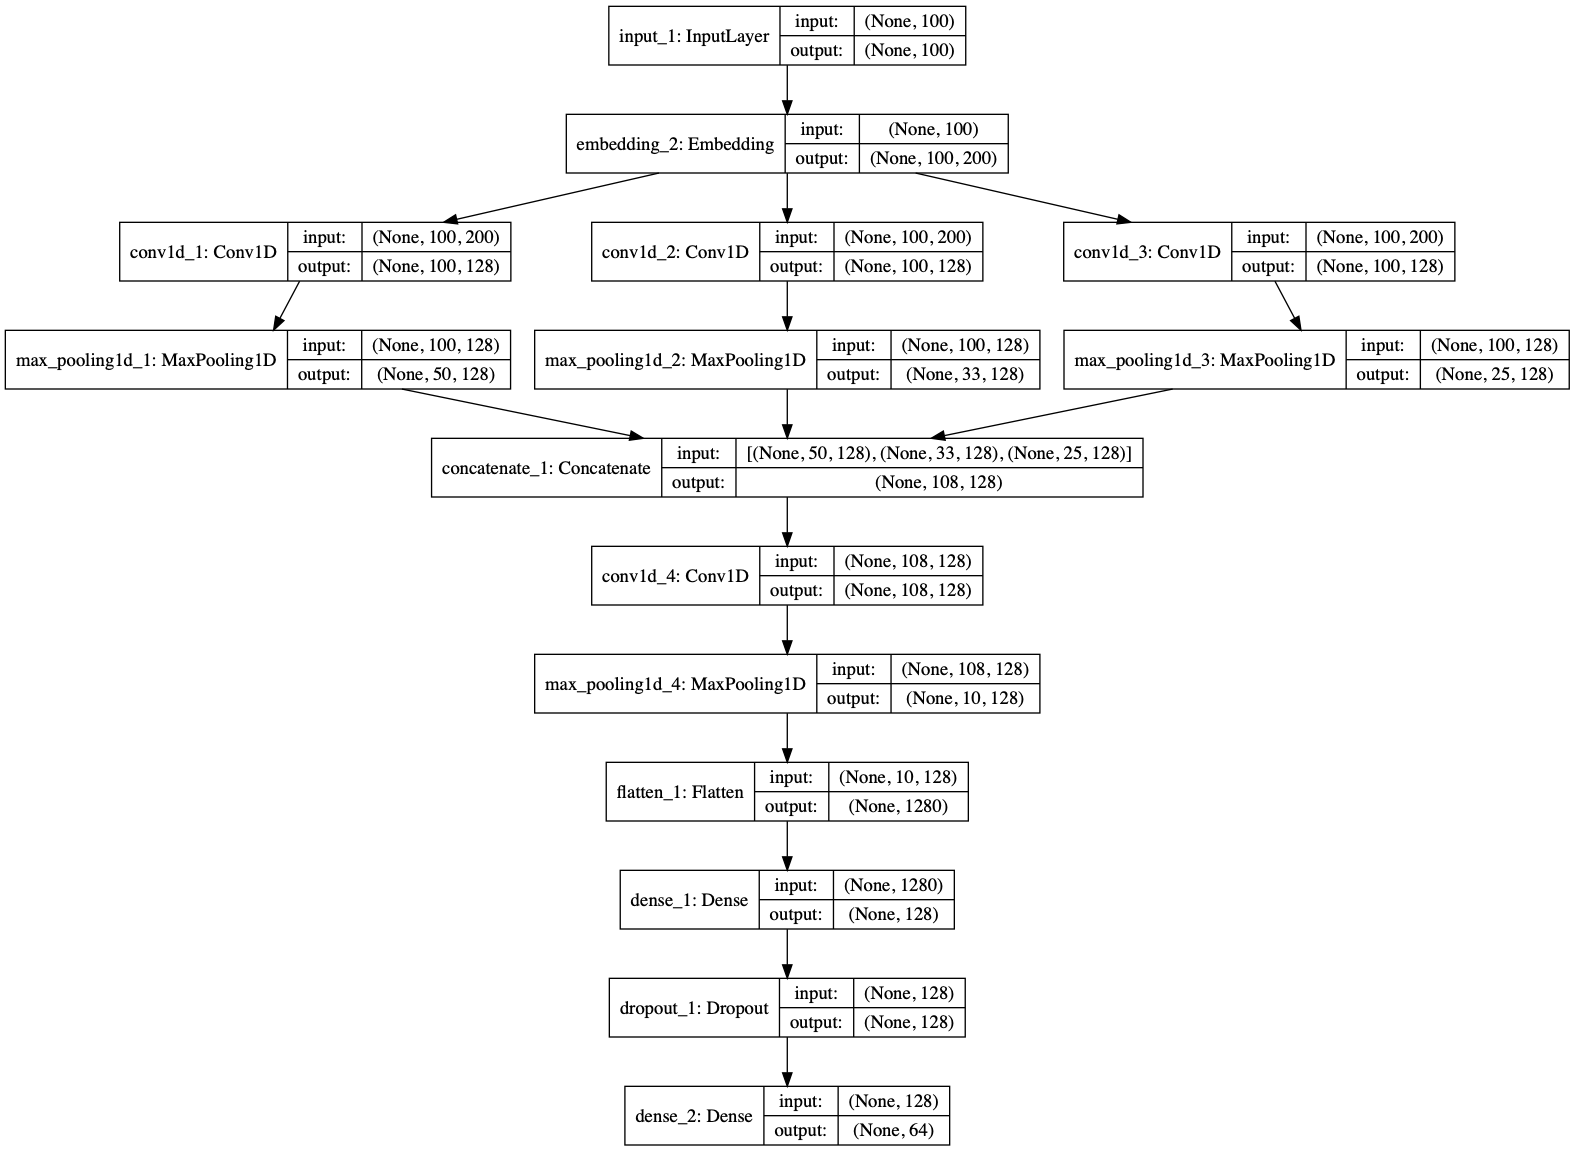

In [46]:
from keras.utils import plot_model
plot_model(encoder,show_shapes=True)

In [48]:
model.fit(features, targets,batch_size =128,epochs = 15,validation_split = 0.3)

Train on 5763 samples, validate on 2471 samples
Epoch 1/10
5763/5763 [==============================] - 7s 1ms/step - loss: 1.8256 - accuracy: 0.4907 - val_loss: 2.0414 - val_accuracy: 0.4589
Epoch 2/10
5763/5763 [==============================] - 7s 1ms/step - loss: 1.6962 - accuracy: 0.5291 - val_loss: 2.0908 - val_accuracy: 0.4427
Epoch 3/10
5763/5763 [==============================] - 7s 1ms/step - loss: 1.6342 - accuracy: 0.5421 - val_loss: 2.0426 - val_accuracy: 0.4614
Epoch 4/10
5763/5763 [==============================] - 7s 1ms/step - loss: 1.4643 - accuracy: 0.5898 - val_loss: 2.1086 - val_accuracy: 0.4601
Epoch 5/10
5763/5763 [==============================] - 7s 1ms/step - loss: 1.4187 - accuracy: 0.5924 - val_loss: 2.1079 - val_accuracy: 0.4771
Epoch 6/10
5763/5763 [==============================] - 8s 1ms/step - loss: 1.3099 - accuracy: 0.6169 - val_loss: 2.1579 - val_accuracy: 0.4723
Epoch 7/10
5763/5763 [==============================] - 7s 1ms/step - loss: 1.0949 - acc

In [88]:
def save_model_user_nlp(encoder,tokenizer,configs, root = 'user_nlp_embedding/resources'):
    encoder_json = encoder.to_json()
    json.dump(encoder_json,open(os.path.join(root,'user_nlp_embedding.json'),'w'))
    encoder.save_weights(os.path.join(root,'user_nlp_embedding.h5'))
    pickle.dump(tokenizer,open(os.path.join(root,'tokenizer.pkl'),'wb'))
    pickle.dump(configs, open(os.path.join(root,'model_config.pkl'),'wb'))

In [74]:
def load_model_user_nlp(root = 'user_nlp_embedding/resources'):
    loaded_model = model_from_json(json.loads(open(os.path.join(root,'user_nlp_embedding.json')).read()))
    loaded_model.load_weights(os.path.join(root,'user_nlp_embedding.h5'))
    return loaded_model

In [93]:
save_model_user_nlp(encoder,tokenizer,configs)

In [77]:
encoder_loaded = load_model_user_nlp()

In [91]:
MAX_SEQUENCE_LENGTH

100

In [ ]:
os.path.join()

In [95]:
configs = pickle.load(open(os.path.join(root,'model_config.pkl'),'rb'))
tokenizer = pickle.load(open(os.path.join(root,'tokenizer.pkl'),'rb'))

In [96]:
tokenizer